In [74]:

import numpy as np
import scipy.signal as sps
import soundfile as sf

def loadToMono(path, new_sr):
    data, sr = sf.read(path)
    print('path:', path)
    print('original data size:', len(data))
    print('original samplerate:', sr)
    
    
    data_mono = []
    for i in range(len(data)):
        data_mono.append((data[i][0] + data[i][1]) / 2)
    
    ret = np.asarray(data_mono)
    samples = round(len(ret) * float(new_sr) / sr)
    ret = sps.resample(np.asarray(ret), samples)
    
    print('new data size:', len(ret))
    print('new samplerate:', new_sr)
    print(' ')
    
    return ret

def add(waves):
    if len(waves) == 1:
        return waves[0]
    elif len(waves) == 0:
        return []
    
    a = waves[0]
    b = waves[1]
    mx = a if a.size > b.size else b
    mn = a if a.size < b.size else b
    z = np.zeros(mx.shape)
    z[:mn.size] = mn
    combined = mx + z
    
    if len(waves) > 2:
        return add([combined] + waves[2:])
    elif len(waves) == 2:
        return combined

samplerate = 8000
a4 = loadToMono('Piano.pp.A4.aiff', samplerate)
g5 = loadToMono('Piano.pp.G5.aiff', samplerate)

data_mono = add([a4, g5])

path: Piano.pp.A4.aiff
original data size: 990905
original samplerate: 44100
new data size: 179756
new samplerate: 8000
 
path: Piano.pp.G5.aiff
original data size: 970095
original samplerate: 44100
new data size: 175981
new samplerate: 8000
 


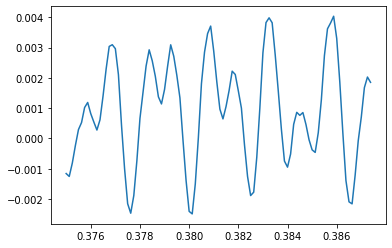

In [75]:
from matplotlib import pyplot

t = [(i) * 1/samplerate for i in range(data_mono.size)]

pyplot.plot(t[3000:3100], data_mono[3000:3100])
pyplot.show()

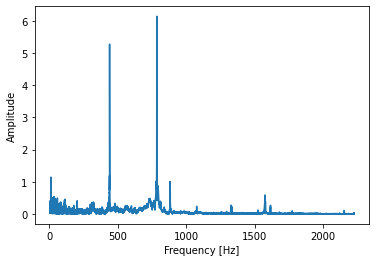

In [81]:
import matplotlib.pyplot as plt
s = np.asarray(data_mono)
fft = np.fft.fft(s)
T = 1/samplerate  # sampling interval 
N = s.size

# 1/T = frequency
f = np.linspace(0, 1 / T, N)

plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
x = f[:N // 2]
y = np.abs(fft)[:N // 2]

a = 100
b = 50000

plt.plot(x[a:b], y[a:b])  # 1 / N is a normalization factor
plt.show()

In [84]:
def findAllAbove(freq, amp, a, discreteTolerance):
    c = amp >= a
    
    maxs = []
    curMax = []
    toleranceCounter = 0
    firstSignal = False

    for i in range(len(y)):
        if c[i]: 
            curMax.append((freq[i], amp[i]))
            firstSignal = True
        else:
            if len(curMax) == 0:
                continue
            else:
                if toleranceCounter > discreteTolerance:
                    m = np.max([x[1] for x in curMax])
                    f = freq[np.where(amp == m)][0]
                    
                    if f > 0.5:
                        maxs.append((f, m))
                    
                    curMax = []
                    toleranceCounter = 0
                    firstSignal = False
                else:
                    if firstSignal:
                        toleranceCounter += 1
    
    return maxs


maxs = findAllAbove(x, y, 1.3, 10)
maxs

[(440.5997051542377, 5.274019357585313),
 (785.1130705682734, 6.140667682017103)]

In [85]:
def filterMultiples(maxs, tol):
    copy = [m for m in maxs]
    mults = []
    cur = []
    
    while len(copy) > 0:
        cur.append(copy[0])
        del copy[0]
        
        removed = 0
        for i in range(len(copy)):
            ratio = copy[i - removed][0] / cur[0][0]
            if abs(ratio - round(ratio)) < tol:
                cur.append(copy[i - removed])
                del copy[i - removed]
                removed += 1
                
        mults.append(cur)
        cur = []
    
    return mults
        
    
filterMultiples(maxs, 0.1)

[[(440.5997051542377, 5.274019357585313)],
 [(785.1130705682734, 6.140667682017103)]]